In [2]:
import pandas as pd
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.metrics import roc_auc_score, roc_curve

In [4]:
# Load pd_train
pd_train_padel = pd.read_csv("data/training_class.csv")
pd_train_padel["label"] = pd_train_padel["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)

# Load ECFP feature set
pd_train_ecfp = pd.read_csv("data/Training_Group_ECFP.csv")

# Merge the two datasets on index (Assuming index represents the row alignment)
# If the index represents the same rows, merge on index
pd_train = pd_train_padel.join(pd_train_ecfp.set_index(pd_train_ecfp.index), rsuffix='_ecfp')

# Drop duplicate 'label' and 'Class' columns from pd_train_ecfp
pd_train = pd_train.drop(columns=["Class_ecfp"])

In [8]:
# Load pd_test
pd_test_padel = pd.read_csv("data/testing_class.csv")
pd_test_padel["label"] = pd_test_padel["Class"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)

# Load ECFP feature set
pd_test_ecfp = pd.read_csv("data/Testing_Group_ECFP.csv")

# Merge the two datasets on index (Assuming index represents the row alignment)
# If the index represents the same rows, merge on index
pd_test = pd_test_padel.join(pd_test_ecfp.set_index(pd_test_ecfp.index), rsuffix='_ecfp')

# Drop duplicate 'label' and 'Class' columns from pd_test_ecfp
pd_test = pd_test.drop(columns=["Class_ecfp"])

In [10]:
# train val split with sklearn
from sklearn.model_selection import train_test_split

features = [col for col in pd_train.columns if col not in ["Class", "label"]]
X_train, X_val, y_train, y_val = train_test_split(
    pd_train[features], pd_train["label"], test_size=0.2, random_state=42
)
X_test = pd_test[features]
y_test = pd_test["label"]

print("Train size: ", X_train.shape)
print("Val size: ", X_val.shape)
print("Test size: ", X_test.shape)

Train size:  (992, 17116)
Val size:  (249, 17116)
Test size:  (286, 17116)


# Train with XGBoost

In [11]:
import xgboost as xgb

In [12]:
%%time
param_init = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth": 4,
    "n_estimators": 1000,
    "learning_rate": 0.025,
    "subsample": 0.7,
    "colsample_bytree": 0.3,
    "colsample_bylevel": 0.5,
    "random_state": 42,
    #
    # "silent": True,
    "n_jobs": 10,
    #
    "tree_method": "hist",
    "grow_policy": "lossguide",
}

param_fit = {
    # "eval_metric": "auc",
    # "early_stopping_rounds": 500,
    "verbose": 200,
    "eval_set": [(X_train, y_train), (X_val, y_val), (X_test, y_test)],
}

xgb_model = xgb.XGBClassifier(**param_init)
xgb_model.fit(X_train, y_train, **param_fit)
evals_result = xgb_model.evals_result()

[0]	validation_0-logloss:0.68526	validation_1-logloss:0.68073	validation_2-logloss:0.64629
[200]	validation_0-logloss:0.37002	validation_1-logloss:0.55597	validation_2-logloss:0.47672
[400]	validation_0-logloss:0.25690	validation_1-logloss:0.56387	validation_2-logloss:0.43343
[600]	validation_0-logloss:0.19266	validation_1-logloss:0.58090	validation_2-logloss:0.41406
[800]	validation_0-logloss:0.15014	validation_1-logloss:0.60854	validation_2-logloss:0.40509
[999]	validation_0-logloss:0.12224	validation_1-logloss:0.63750	validation_2-logloss:0.40380
CPU times: total: 27min 26s
Wall time: 7min 27s


In [13]:
# save model with joblib current datetime
# joblib.dump(xgb_model, f"models/xgb_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib")
joblib.dump(xgb_model, f"models/xgb_combine_ecfp.joblib")

['models/xgb_combine_ecfp.joblib']

# Model evaluates

In [14]:
# load model
xgb_model = joblib.load("models/xgb_combine_ecfp.joblib")

In [ ]:
#
n_features = X_train.shape[1]
fig, ax = plt.subplots(figsize=(10, n_features // 10))
plot_importance(xgb_model, ax=ax)
plt.show()

In [15]:
# print top features importance
top_features = xgb_model.get_booster().get_fscore()
top_features = sorted(top_features.items(), key=lambda x: x[1], reverse=True)
print("Top features importance")
for i, (feature, importance) in enumerate(top_features[:20]):
    print(f"{i+1}. {feature}: {importance}")

Top features importance
1. SubFPC300: 47.0
2. SubFPC307: 45.0
3. KRFPC297: 44.0
4. APC2D1_C_C: 38.0
5. SubFPC302: 37.0
6. APC2D8_C_O: 36.0
7. SubFPC295: 35.0
8. APC2D3_C_C: 35.0
9. KRFPC341: 34.0
10. APC2D2_C_C: 34.0
11. APC2D5_C_O: 33.0
12. SubFPC301: 32.0
13. APC2D4_C_C: 32.0
14. APC2D5_C_C: 32.0
15. APC2D7_C_C: 32.0
16. FP141: 31.0
17. APC2D4_C_O: 30.0
18. ExtFP456: 28.0
19. APC2D8_C_C: 28.0
20. FP1007: 26.0


In [16]:
# check AUC
y_train_pred = xgb_model.predict_proba(X_train)[:, 1]
y_val_pred = xgb_model.predict_proba(X_val)[:, 1]
y_test_pred = xgb_model.predict_proba(X_test)[:, 1]

print("Train AUC: ", roc_auc_score(y_train, y_train_pred))
print("Val AUC: ", roc_auc_score(y_val, y_val_pred))
print("Test AUC: ", roc_auc_score(y_test, y_test_pred))

Train AUC:  0.9988364470665355
Val AUC:  0.7545190658398206
Test AUC:  0.9061608075182734


In [17]:
def visualize_auc(y, y_pred):
    auc_value = roc_auc_score(y, y_pred)
    res01 = roc_curve(y, y_pred)

    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    lw = 2
    ax1.plot(res01[0], res01[1], color="darkorange", lw=lw, label="ROC")
    ax1.plot([0, 1], [0, 1], color="navy", label="Random", lw=lw, linestyle="--")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("AUC = %0.5f" % (auc_value))
    ax1.legend(loc="lower right")

    ax2.set_title("Set (size: {})".format(y.shape[0]))
    ax2.hist(y_pred, bins=200)

    plt.show()

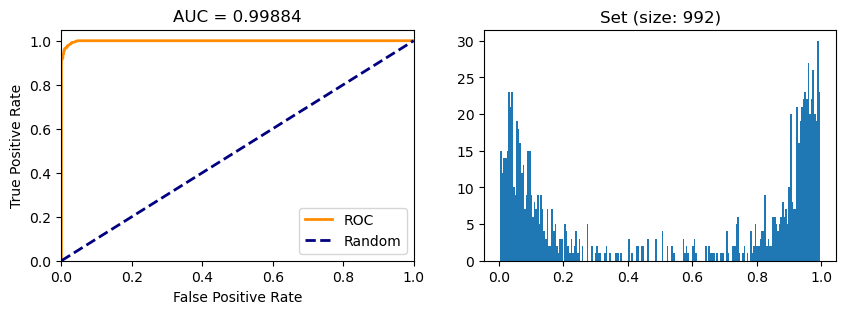

In [18]:
visualize_auc(y_train, y_train_pred)

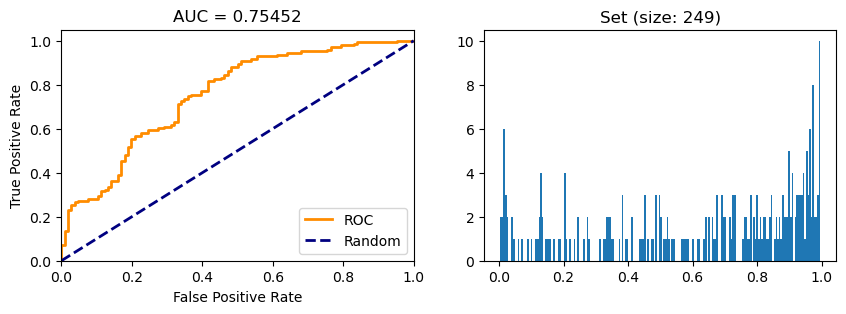

In [19]:
visualize_auc(y_val, y_val_pred)

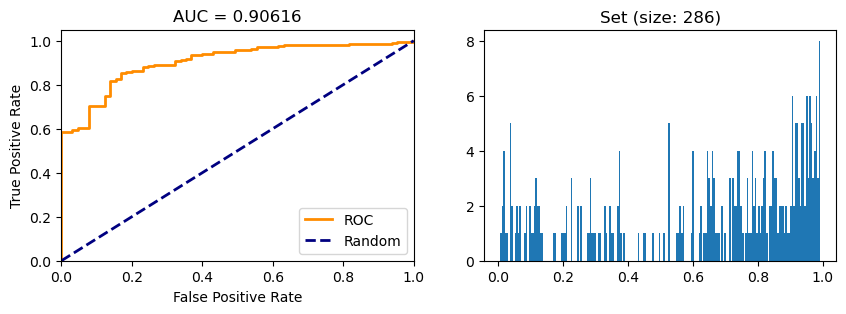

In [20]:
visualize_auc(y_test, y_test_pred)